# Loading Data for ML Applications

In this notebook, we will implement code to load data for ML applications. Following the approach used by `PyTorch`, we will implement a `Dataset` class and a `DataLoader` class. The `Dataset` class will be used to load the data and the `DataLoader` class will be used to iterate over the data in batches.

We will test it on a simple image dataset.

## The `Dataset` Class

First, we need some way of representing how each individual item will be pre-processed as the dataloader iterates over the data. We will do this by creating a `Dataset` class. Since this class represents multiple items in our dataset, we will need to define the following special methods:

- `__len__`: returns the length of the dataset
- `__getitem__`: returns the item at a given index

## The Intel Image Classification Dataset

We will use the [Intel Image Classification Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) from Kaggle. This dataset contains images of natural scenes around the world. The dataset contains 25,000 images of size 150x150 distributed under 6 categories. The dataset is divided into a training set and a test set. The training set contains 14k images. The images are organized under folder representing each category. When initializing our dataset, it should iterate through the folders to enumerate all the images and their corresponding labels.

In [4]:
import os

class IntelDataset:
    def __init__(self, data_path):
        self.data_path = data_path
        self.classes, self.class_to_idx = self._find_classes(self.data_path)
        self.samples = self._make_dataset(self.data_path, self.class_to_idx)
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raise NotImplementedError

    def _find_classes(self, path):
        """Summarized from torchvision.datasets.ImageFolder"""
        classes = [d.name for d in os.scandir(path) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        return classes, class_to_idx
    
    def _make_dataset(self, dir, class_to_idx):
        """Summarized from torchvision.datasets.ImageFolder"""
        images = []
        dir = os.path.expanduser(dir)
        for target in sorted(os.listdir(dir)):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue
            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)
                    
        return images


Here is the first iteration of our dataset. Let's test it on the Intel Image Classification dataset available here: https://www.kaggle.com/datasets/puneet6060/intel-image-classification.

We will use the training samples to test our `Dataset` class. There are 14,000 images in the training set over 6 categories. Each category is contained in its own subfolder.

In [8]:
dataset = IntelDataset(data_path='data/seg_train')

print(dataset.classes)
print(dataset.class_to_idx)
print(len(dataset))

# Sample the first 5 items
for i in range(5):
    print(dataset.samples[i])

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
14034
('data/seg_train/buildings/0.jpg', 0)
('data/seg_train/buildings/10006.jpg', 0)
('data/seg_train/buildings/1001.jpg', 0)
('data/seg_train/buildings/10014.jpg', 0)
('data/seg_train/buildings/10018.jpg', 0)


### Loading the Images

Now that we can successfully initialize the dataset, we can implement `__getitem__` to load the actual image and return a tuple of the image and its label. We will use the `PIL` library to load the image and convert it to a `numpy` array.

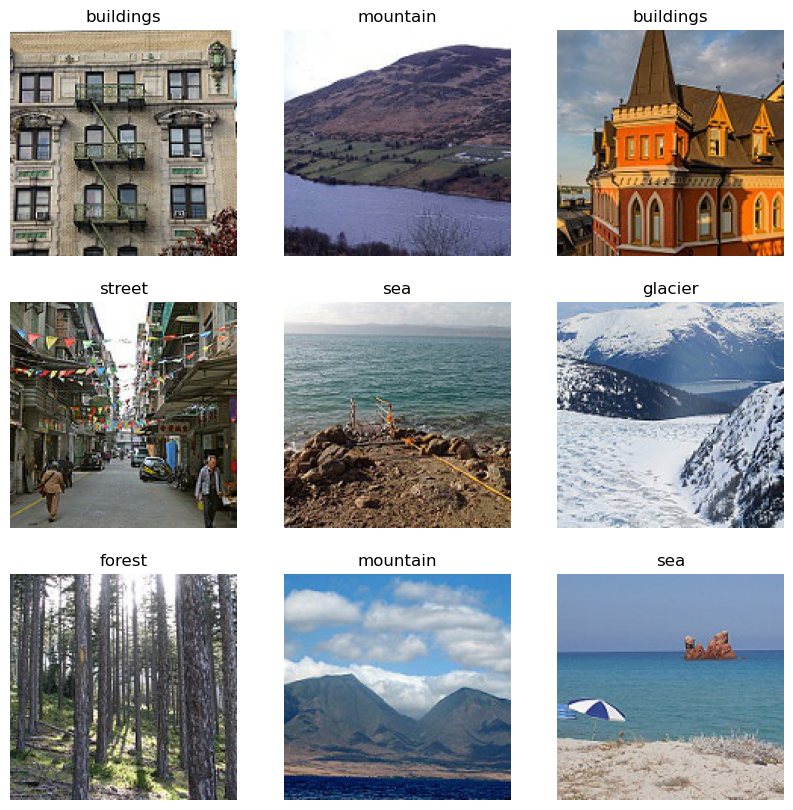

In [10]:
import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class IntelDataset:
    def __init__(self, data_path):
        self.data_path = data_path
        self.classes, self.class_to_idx = self._find_classes(self.data_path)
        self.samples = self._make_dataset(self.data_path, self.class_to_idx)
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        image = Image.open(path).convert('RGB')
        image = np.array(image)
        
        return image, target

    def _find_classes(self, path):
        """Summarized from torchvision.datasets.ImageFolder"""
        classes = [d.name for d in os.scandir(path) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        return classes, class_to_idx
    
    def _make_dataset(self, dir, class_to_idx):
        """Summarized from torchvision.datasets.ImageFolder"""
        images = []
        dir = os.path.expanduser(dir)
        for target in sorted(os.listdir(dir)):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue
            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)
                    
        return images

# Sample 9 random images and display them with their labels
dataset = IntelDataset(data_path='data/seg_train')

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = np.random.randint(len(dataset))
        image, target = dataset[idx]
        axes[i, j].imshow(image)
        axes[i, j].set_title(dataset.classes[target])
        axes[i, j].axis('off')

plt.show()

## The `DataLoader` Class

Now that we have a `Dataset` to manage loading each individual item, we need to create a `DataLoader` that is responsible for iterating over the dataset in batches.


In [24]:
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return len(self.dataset) // self.batch_size
    
    def __iter__(self):
        if self.shuffle:
            indices = np.random.permutation(len(self.dataset))
        else:
            indices = np.arange(len(self.dataset))
            
        for i in range(len(self)):
            batch_indices = indices[i*self.batch_size:(i+1)*self.batch_size]
            batch = [self.dataset[idx] for idx in batch_indices]
            images, targets = zip(*batch)
            images = np.stack(images, axis=0)
            targets = np.stack(targets, axis=0)
            
            yield images, targets

In this example, the `__iter__` uses Python generators to yield a batch of data instead of overriding the `__next__` method.

Let's test this with our dataset.

In [29]:
dataset = IntelDataset(data_path='data/seg_train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

for images, targets in dataloader:
    print(images.shape, targets.shape)

(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 150, 3) (1,)
(1, 150, 1

## Cleaning the Data

Our data loader failed because there are some images that are not $150 \times 150$. We need to figure out exactly what to do with those images. We can either remove them or resize them so that they are all the same size. We will resize them to $150 \times 150$. This will be easiest to do in the `__getitem__` method of our `Dataset` class.

In [41]:
import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class IntelDataset:
    def __init__(self, data_path):
        self.data_path = data_path
        self.classes, self.class_to_idx = self._find_classes(self.data_path)
        self.samples = self._make_dataset(self.data_path, self.class_to_idx)
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        image = Image.open(path).convert('RGB')

        # Resize if the image is not 150x150
        if image.size != (150, 150):
            image = image.resize((150, 150))

        image = np.array(image)
        
        return image, target

    def _find_classes(self, path):
        """Summarized from torchvision.datasets.ImageFolder"""
        classes = [d.name for d in os.scandir(path) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        return classes, class_to_idx
    
    def _make_dataset(self, dir, class_to_idx):
        """Summarized from torchvision.datasets.ImageFolder"""
        images = []
        dir = os.path.expanduser(dir)
        for target in sorted(os.listdir(dir)):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue
            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)
                    
        return images

In [45]:
dataset = IntelDataset(data_path='data/seg_train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Verify that our fix works!
for images, targets in dataloader:
    print(images.shape, targets.shape)

(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3) (32,)
(32, 150, 150, 3